## Classification using siamese model

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [3]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [5]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = 1000

In [6]:
DOMAIN = 'netbeans'
METHOD = 'baseline_dwen_{}'.format(epochs)
PREPROCESSING = 'bert'
TOKEN = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [7]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K

K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
import keras.backend as K

MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D

(20, 20)

In [9]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_severity': 7,
 'bug_status': 3,
 'component': 473,
 'priority': 4,
 'product': 39,
 'version': 18}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [14]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


216715

#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 21.7 s, sys: 2.35 s, total: 24.1 s
Wall time: 23.4 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 3.43 s, sys: 23.3 ms, total: 3.45 s
Wall time: 3.42 s


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)

CPU times: user 200 ms, sys: 3.76 ms, total: 204 ms
Wall time: 203 ms


In [18]:
len(bug_train_ids)

2560212

In [19]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path='test_chronological')

Reading test data for classification
CPU times: user 118 ms, sys: 3.38 ms, total: 121 ms
Wall time: 119 ms


In [20]:
len(baseline.test_data)

57954

## Siamese  model

In [21]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [22]:
from keras.layers import concatenate, Dropout, Add

bug_t_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b_input = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
    
title_embed = similarity_model.get_layer('embedding_layer_title')
desc_embed = similarity_model.get_layer('embedding_layer_desc')
title_encoder = similarity_model.get_layer('global_average_pooling1d_1')
desc_encoder = similarity_model.get_layer('global_average_pooling1d_2')

# Bug A
bug_t_a_embed = title_embed(bug_t_a_input)
bug_d_a_embed = desc_embed(bug_d_a_input)
# Bug B
bug_t_b_embed = title_embed(bug_t_b_input)
bug_d_b_embed = desc_embed(bug_d_b_input)

# Bug A
bug_t_a = title_encoder(bug_t_a_embed)
bug_d_a = desc_encoder(bug_d_a_embed)
# Bug B
bug_t_b = title_encoder(bug_t_b_embed)
bug_d_b = desc_encoder(bug_d_b_embed)

model = similarity_model.get_layer('merge_features_dwen_a')

bug_a = model([bug_t_a, bug_d_a])
bug_b = model([bug_t_b, bug_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    # x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_input, bug_t_b_input, bug_d_a_input, bug_d_b_input], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 20)           0                                            
__________________________________________________________________________________________________
title_b (InputLayer)            (None, 20)           0                                            
________________________________________________________________________________________________

In [23]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [24]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [25]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(retrieval, None, train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg,
                                                                                    issues_by_buckets)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [26]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1, bug_train_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [27]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/100
 3/10 [========>.....................] - ETA: 6s - loss: 0.7422 - acc: 0.4971

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110959). Check your callbacks.
  % delta_t_median)


 4/10 [===========>..................] - ETA: 5s - loss: 0.7380 - acc: 0.5029

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103022). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 9s 869ms/step - loss: 0.7192 - acc: 0.5198 - val_loss: 0.6649 - val_acc: 0.5859
Epoch 2/100
10/10 [==============================] - 8s 833ms/step - loss: 0.6834 - acc: 0.5643 - val_loss: 0.6500 - val_acc: 0.6543
Epoch 3/100
10/10 [==============================] - 8s 843ms/step - loss: 0.6609 - acc: 0.6032 - val_loss: 0.6332 - val_acc: 0.6797
Epoch 4/100
10/10 [==============================] - 8s 841ms/step - loss: 0.6411 - acc: 0.6415 - val_loss: 0.6131 - val_acc: 0.6914
Epoch 5/100
10/10 [==============================] - 8s 844ms/step - loss: 0.6196 - acc: 0.6614 - val_loss: 0.5937 - val_acc: 0.6973
Epoch 6/100
10/10 [==============================] - 8s 832ms/step - loss: 0.5958 - acc: 0.6823 - val_loss: 0.5771 - val_acc: 0.7109
Epoch 7/100
10/10 [==============================] - 8s 833ms/step - loss: 0.5883 - acc: 0.6867 - val_loss: 0.5755 - val_acc: 0.6797
Epoch 8/100
10/10 [==============================] - 8s 831ms/step - loss: 0.5794

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122895). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 837ms/step - loss: 0.5471 - acc: 0.7253 - val_loss: 0.5479 - val_acc: 0.7109
Epoch 18/100
10/10 [==============================] - 8s 828ms/step - loss: 0.5524 - acc: 0.7117 - val_loss: 0.5383 - val_acc: 0.7285
Epoch 19/100
10/10 [==============================] - 8s 822ms/step - loss: 0.5506 - acc: 0.7182 - val_loss: 0.5400 - val_acc: 0.7227
Epoch 20/100
10/10 [==============================] - 8s 833ms/step - loss: 0.5415 - acc: 0.7188 - val_loss: 0.5388 - val_acc: 0.7168
Epoch 21/100
10/10 [==============================] - 8s 834ms/step - loss: 0.5372 - acc: 0.7261 - val_loss: 0.5433 - val_acc: 0.7246
Epoch 22/100
10/10 [==============================] - 8s 829ms/step - loss: 0.5407 - acc: 0.7255 - val_loss: 0.5380 - val_acc: 0.7227
Epoch 23/100
10/10 [==============================] - 8s 822ms/step - loss: 0.5446 - acc: 0.7190 - val_loss: 0.5371 - val_acc: 0.7168
Epoch 24/100
10/10 [==============================] - 8s 838ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104455). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 836ms/step - loss: 0.5501 - acc: 0.7159 - val_loss: 0.5366 - val_acc: 0.7129
Epoch 27/100
10/10 [==============================] - 8s 828ms/step - loss: 0.5474 - acc: 0.7261 - val_loss: 0.5346 - val_acc: 0.7207
Epoch 28/100
10/10 [==============================] - 8s 839ms/step - loss: 0.5337 - acc: 0.7332 - val_loss: 0.5308 - val_acc: 0.7148
Epoch 29/100
10/10 [==============================] - 8s 842ms/step - loss: 0.5439 - acc: 0.7217 - val_loss: 0.5329 - val_acc: 0.7227
Epoch 30/100
10/10 [==============================] - 8s 841ms/step - loss: 0.5391 - acc: 0.7325 - val_loss: 0.5291 - val_acc: 0.7246
Epoch 31/100
10/10 [==============================] - 8s 843ms/step - loss: 0.5327 - acc: 0.7310 - val_loss: 0.5289 - val_acc: 0.7168
Epoch 32/100
10/10 [==============================] - 8s 831ms/step - loss: 0.5334 - acc: 0.7257 - val_loss: 0.5297 - val_acc: 0.7227
Epoch 33/100
10/10 [==============================] - 8s 830ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147706). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.5228 - acc: 0.7373

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138400). Check your callbacks.
  % delta_t_median)


 4/10 [===========>..................] - ETA: 4s - loss: 0.5174 - acc: 0.7449

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128054). Check your callbacks.
  % delta_t_median)


 5/10 [==============>...............] - ETA: 3s - loss: 0.5222 - acc: 0.7414

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117707). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 824ms/step - loss: 0.5276 - acc: 0.7369 - val_loss: 0.5233 - val_acc: 0.7383
Epoch 38/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.5620 - acc: 0.7285

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133749). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 831ms/step - loss: 0.5329 - acc: 0.7310 - val_loss: 0.5215 - val_acc: 0.7383
Epoch 39/100
10/10 [==============================] - 8s 831ms/step - loss: 0.5243 - acc: 0.7353 - val_loss: 0.5225 - val_acc: 0.7480
Epoch 40/100
10/10 [==============================] - 8s 829ms/step - loss: 0.5281 - acc: 0.7347 - val_loss: 0.5217 - val_acc: 0.7324
Epoch 41/100
10/10 [==============================] - 8s 831ms/step - loss: 0.5252 - acc: 0.7391 - val_loss: 0.5239 - val_acc: 0.7266
Epoch 42/100
10/10 [==============================] - 8s 831ms/step - loss: 0.5293 - acc: 0.7358 - val_loss: 0.5228 - val_acc: 0.7305
Epoch 43/100
10/10 [==============================] - 8s 833ms/step - loss: 0.5171 - acc: 0.7393 - val_loss: 0.5205 - val_acc: 0.7344
Epoch 44/100
10/10 [==============================] - 8s 834ms/step - loss: 0.5296 - acc: 0.7321 - val_loss: 0.5217 - val_acc: 0.7305
Epoch 45/100
10/10 [==============================] - 8s 823ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101339). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 6s - loss: 0.5312 - acc: 0.7358

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125051). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 830ms/step - loss: 0.5226 - acc: 0.7404 - val_loss: 0.5150 - val_acc: 0.7266
Epoch 51/100
10/10 [==============================] - 8s 845ms/step - loss: 0.5138 - acc: 0.7453 - val_loss: 0.5161 - val_acc: 0.7383
Epoch 52/100
10/10 [==============================] - 8s 818ms/step - loss: 0.5231 - acc: 0.7356 - val_loss: 0.5170 - val_acc: 0.7344
Epoch 53/100
10/10 [==============================] - 8s 837ms/step - loss: 0.5133 - acc: 0.7407 - val_loss: 0.5153 - val_acc: 0.7363
Epoch 54/100
10/10 [==============================] - 8s 820ms/step - loss: 0.5180 - acc: 0.7404 - val_loss: 0.5123 - val_acc: 0.7422
Epoch 55/100
10/10 [==============================] - 8s 828ms/step - loss: 0.5129 - acc: 0.7434 - val_loss: 0.5126 - val_acc: 0.7363
Epoch 56/100
10/10 [==============================] - 8s 827ms/step - loss: 0.5143 - acc: 0.7421 - val_loss: 0.5201 - val_acc: 0.7324
Epoch 57/100
10/10 [==============================] - 8s 831ms/step - loss:

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134013). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 6s - loss: 0.5158 - acc: 0.7495

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118534). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.5248 - acc: 0.7409

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123166). Check your callbacks.
  % delta_t_median)


 4/10 [===========>..................] - ETA: 4s - loss: 0.5204 - acc: 0.7451

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113111). Check your callbacks.
  % delta_t_median)


 5/10 [==============>...............] - ETA: 4s - loss: 0.5134 - acc: 0.7500

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103055). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 832ms/step - loss: 0.5095 - acc: 0.7483 - val_loss: 0.5015 - val_acc: 0.7383
Epoch 70/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.5015 - acc: 0.7529

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144277). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.5014 - acc: 0.7497

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128464). Check your callbacks.
  % delta_t_median)


 4/10 [===========>..................] - ETA: 4s - loss: 0.5047 - acc: 0.7498

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115894). Check your callbacks.
  % delta_t_median)


 5/10 [==============>...............] - ETA: 4s - loss: 0.5108 - acc: 0.7436

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103324). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 832ms/step - loss: 0.5090 - acc: 0.7449 - val_loss: 0.5027 - val_acc: 0.7441
Epoch 71/100
10/10 [==============================] - 8s 829ms/step - loss: 0.5056 - acc: 0.7446 - val_loss: 0.4990 - val_acc: 0.7441
Epoch 72/100
10/10 [==============================] - 8s 833ms/step - loss: 0.4983 - acc: 0.7502 - val_loss: 0.4984 - val_acc: 0.7441
Epoch 73/100
10/10 [==============================] - 8s 832ms/step - loss: 0.5026 - acc: 0.7490 - val_loss: 0.4974 - val_acc: 0.7480
Epoch 74/100
10/10 [==============================] - 8s 835ms/step - loss: 0.4936 - acc: 0.7547 - val_loss: 0.5008 - val_acc: 0.7461
Epoch 75/100
10/10 [==============================] - 8s 826ms/step - loss: 0.5010 - acc: 0.7519 - val_loss: 0.5074 - val_acc: 0.7500
Epoch 76/100
 2/10 [=====>........................] - ETA: 6s - loss: 0.4946 - acc: 0.7603

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107166). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 826ms/step - loss: 0.4995 - acc: 0.7509 - val_loss: 0.5030 - val_acc: 0.7441
Epoch 77/100
10/10 [==============================] - 8s 833ms/step - loss: 0.5000 - acc: 0.7533 - val_loss: 0.4943 - val_acc: 0.7461
Epoch 78/100
10/10 [==============================] - 8s 831ms/step - loss: 0.5004 - acc: 0.7524 - val_loss: 0.4996 - val_acc: 0.7461
Epoch 79/100
10/10 [==============================] - 8s 833ms/step - loss: 0.5053 - acc: 0.7456 - val_loss: 0.4989 - val_acc: 0.7480
Epoch 80/100
10/10 [==============================] - 8s 823ms/step - loss: 0.4876 - acc: 0.7618 - val_loss: 0.5057 - val_acc: 0.7559
Epoch 81/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.5122 - acc: 0.7510

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102729). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 6s - loss: 0.5079 - acc: 0.7510

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110257). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 825ms/step - loss: 0.4954 - acc: 0.7570 - val_loss: 0.4998 - val_acc: 0.7559
Epoch 82/100
10/10 [==============================] - 8s 824ms/step - loss: 0.4907 - acc: 0.7562 - val_loss: 0.5011 - val_acc: 0.7480
Epoch 83/100
10/10 [==============================] - 8s 819ms/step - loss: 0.4922 - acc: 0.7553 - val_loss: 0.4986 - val_acc: 0.7461
Epoch 84/100
10/10 [==============================] - 8s 825ms/step - loss: 0.5053 - acc: 0.7514 - val_loss: 0.5010 - val_acc: 0.7500
Epoch 85/100
10/10 [==============================] - 8s 829ms/step - loss: 0.4953 - acc: 0.7513 - val_loss: 0.4911 - val_acc: 0.7559
Epoch 86/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.4990 - acc: 0.7451

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133628). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 829ms/step - loss: 0.4960 - acc: 0.7520 - val_loss: 0.4938 - val_acc: 0.7422
Epoch 87/100
10/10 [==============================] - 8s 831ms/step - loss: 0.4848 - acc: 0.7581 - val_loss: 0.5003 - val_acc: 0.7461
Epoch 88/100
10/10 [==============================] - 8s 825ms/step - loss: 0.5008 - acc: 0.7526 - val_loss: 0.5072 - val_acc: 0.7422
Epoch 89/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.4823 - acc: 0.7783

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154199). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 829ms/step - loss: 0.4864 - acc: 0.7614 - val_loss: 0.4867 - val_acc: 0.7617
Epoch 90/100
10/10 [==============================] - 8s 832ms/step - loss: 0.4901 - acc: 0.7563 - val_loss: 0.4879 - val_acc: 0.7500
Epoch 91/100
10/10 [==============================] - 8s 830ms/step - loss: 0.4985 - acc: 0.7462 - val_loss: 0.4965 - val_acc: 0.7461
Epoch 92/100
10/10 [==============================] - 8s 825ms/step - loss: 0.4937 - acc: 0.7523 - val_loss: 0.5019 - val_acc: 0.7461
Epoch 93/100
 1/10 [==>...........................] - ETA: 6s - loss: 0.4682 - acc: 0.7559

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144153). Check your callbacks.
  % delta_t_median)


 2/10 [=====>........................] - ETA: 6s - loss: 0.4810 - acc: 0.7603

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126271). Check your callbacks.
  % delta_t_median)


 3/10 [========>.....................] - ETA: 5s - loss: 0.4856 - acc: 0.7542

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108389). Check your callbacks.
  % delta_t_median)


 4/10 [===========>..................] - ETA: 4s - loss: 0.4837 - acc: 0.7573

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112935). Check your callbacks.
  % delta_t_median)


10/10 [==============================] - 8s 838ms/step - loss: 0.4836 - acc: 0.7597 - val_loss: 0.4889 - val_acc: 0.7656
Epoch 94/100
10/10 [==============================] - 8s 824ms/step - loss: 0.4921 - acc: 0.7570 - val_loss: 0.4877 - val_acc: 0.7617
Epoch 95/100
10/10 [==============================] - 8s 830ms/step - loss: 0.4892 - acc: 0.7619 - val_loss: 0.4861 - val_acc: 0.7734
Epoch 96/100
10/10 [==============================] - 8s 830ms/step - loss: 0.4849 - acc: 0.7611 - val_loss: 0.4956 - val_acc: 0.7520
Epoch 97/100
10/10 [==============================] - 8s 831ms/step - loss: 0.4819 - acc: 0.7592 - val_loss: 0.4886 - val_acc: 0.7578
Epoch 98/100
10/10 [==============================] - 8s 826ms/step - loss: 0.4855 - acc: 0.7648 - val_loss: 0.4806 - val_acc: 0.7617
Epoch 99/100
10/10 [==============================] - 8s 830ms/step - loss: 0.4902 - acc: 0.7559 - val_loss: 0.4868 - val_acc: 0.7578
Epoch 100/100
10/10 [==============================] - 8s 829ms/step - loss

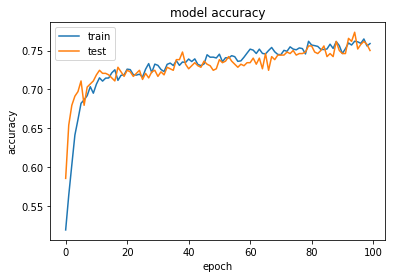

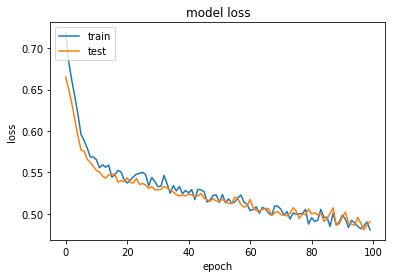

In [28]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [29]:
result = { }

In [30]:
number_of_pairs = len(baseline.test_data)

#### train

In [31]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, number_of_pairs, 1, 
                                                                             bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
acc_train

0.761172654174

#### test

In [32]:
from sklearn.metrics import accuracy_score

number_of_pairs = len(baseline.test_data)

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
acc_test

0.7094419712185527

### Roc AUC/SCORE

#### train

In [33]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_train = roc_auc_score(y_true, y_scores)
roc_train

0.8520743578430765

#### test

In [34]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b])

roc_test = roc_auc_score(y_true, y_scores)
roc_test

0.7939145406705856

In [35]:
pred = np.argmax(y_scores, axis=1)
pred = pred.tolist()
pred

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,


In [36]:
label = np.argmax(y_true, axis=1)
label = label.tolist()
label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Normalized confusion matrix
[[0.63427891 0.36572109]
 [0.21539497 0.78460503]]


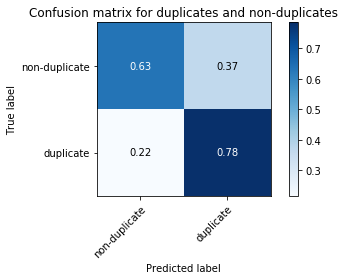

In [37]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")

Normalized confusion matrix
[[0.63427891 0.36572109]
 [0.21539497 0.78460503]]


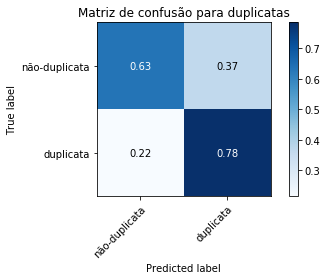

In [38]:
import matplotlib.pyplot as plt

ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicata', 'duplicata']), 
                      title='Matriz de confusão para duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")

#### Save the model

In [39]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [42]:
import _pickle as pickle

CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [43]:
result

{'acc_test': 0.7094419712185527,
 'acc_train': 0.761172654174,
 'method': 'baseline_dwen_1000',
 'roc_test': 0.7939145406705856,
 'roc_train': 0.8520743578430765}